In [742]:
from IPython.display import clear_output
import pdb, time, math, numpy as np, gc, importlib, torch, os, cv2 as cv, ODEModel, matplotlib
import ot
import matplotlib.pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F 
from torch.autograd import Variable
from torch.distributions import MultivariateNormal
from torchdiffeq import odeint_adjoint as odeint 
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import Utils, LearnVelTraj
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory, ezshow, SaveTrajectory as st, MiscTransforms
importlib.reload(ODEModel)
from ODEModel import velocMLP, FfjordModel
importlib.reload(LearnVelTraj);
from LearnVelTraj import learn_vel_trajectory

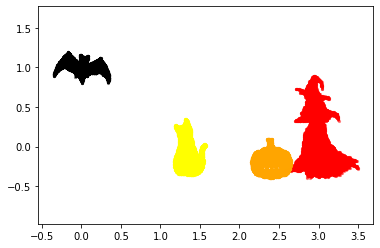

In [749]:
# ## TRAIN halloween ish. Concatenated OT maps only.
f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
f2 = ImageDataset('frames/cat2.png',noise_std=0); 
f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

n_inner = 10000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

ezshow(dat1, col='red')
ezshow(dat2, col='yellow')
ezshow(dat3, col='orange')
ezshow(dat4, col='black')

outfolder = "results/experiment_spook_cubic_OT/"
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));

xt_trajs_OT = st.get_cubic_OT_trajectory(keyframes, nsteps=20, n=2000)

st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render',
                       dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False)
st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render_tight',
                       dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False,tightBB=False)


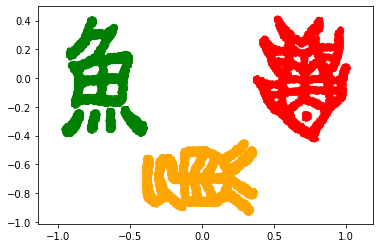

In [748]:
# ## TRAIN FISH234: Use OT cubic splines
# f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
# f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
# f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

# ezshow(dat2, col='red')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat2, dat3, dat4)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_fish234_OT_cubic/"

# xt_trajs_OT = st.get_cubic_OT_trajectory(keyframes, nsteps=20, n=2000)

# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='cubic_OT_render',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False)
# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='cubic_OT_render_tight',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False,tightBB=False)


In [723]:
# # ## TRAIN halloween ish. Concatenated OT maps only.
# # f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# # f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# # f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# # f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# # n_inner = 10000;
# # n_sil = 10000 - n_inner;
# # dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# # dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# # dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# # dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# # ezshow(dat1, col='red')
# # ezshow(dat2, col='yellow')
# # ezshow(dat3, col='orange')
# # ezshow(dat4, col='black')

# # outfolder = "results/experiment_spook_OT/"

# # keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# # xt_trajs_OT = st.get_OT_trajectory(keyframes, nsteps=20, n=2000, ot_type=2)

# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False)
# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False,tightBB=False)


  0%|          | 1/300 [00:01<08:40,  1.74s/it]

Allocated: 0.24 GB  Reserved: 15.63 GB
[Loss: 1.4146 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.7420 | Iter: 1.7405 | fit: 0.2316 | reg: 0.1706 | save: 0.0000) | autograd: 1.3363]


 17%|█▋        | 51/300 [01:48<18:37,  4.49s/it]

Allocated: 0.24 GB  Reserved: 15.63 GB
[Loss: 0.1829 | lr: 0.0001 | n_subsample: 378] 
[Total time : 108.9995 | Iter: 99.0798 | fit: 0.2894 | reg: 0.2283 | save: 8.1761) | autograd: 1.4624]


 34%|███▎      | 101/300 [03:43<15:38,  4.71s/it]

Allocated: 0.21 GB  Reserved: 15.63 GB
[Loss: 0.0991 | lr: 0.0001 | n_subsample: 476] 
[Total time : 223.5677 | Iter: 106.0126 | fit: 0.3489 | reg: 0.2621 | save: 8.5547) | autograd: 1.5908]


 50%|█████     | 151/300 [05:39<11:23,  4.59s/it]

Allocated: 0.21 GB  Reserved: 15.63 GB
[Loss: 0.1062 | lr: 5e-05 | n_subsample: 600] 
[Total time : 339.9136 | Iter: 108.5959 | fit: 0.3056 | reg: 0.2454 | save: 7.7487) | autograd: 1.7722]


 67%|██████▋   | 201/300 [07:39<07:44,  4.69s/it]

Allocated: 0.21 GB  Reserved: 15.63 GB
[Loss: 0.1006 | lr: 5e-05 | n_subsample: 756] 
[Total time : 459.6467 | Iter: 111.5456 | fit: 0.3261 | reg: 0.2496 | save: 8.1854) | autograd: 1.5852]


 84%|████████▎ | 251/300 [09:44<03:50,  4.71s/it]

Allocated: 0.21 GB  Reserved: 15.63 GB
[Loss: 0.0715 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 584.5229 | Iter: 116.8877 | fit: 0.3193 | reg: 0.2703 | save: 7.9845) | autograd: 1.6905]


100%|██████████| 300/300 [11:48<00:00,  2.36s/it]

Allocated: 0.21 GB  Reserved: 15.63 GB
[Loss: 0.0707 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 708.8443 | Iter: 116.5528 | fit: 0.3040 | reg: 0.2370 | save: 7.7665) | autograd: 1.6499]


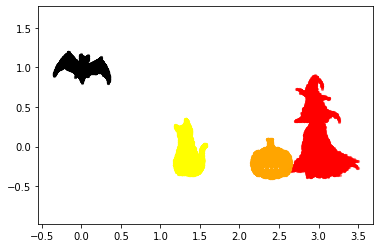

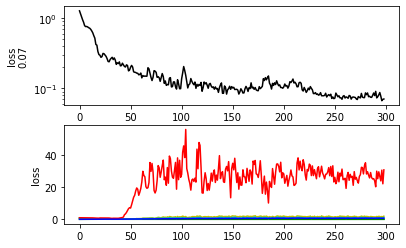

In [708]:
# ## TRAIN halloween ish. jerk .01, polar .1
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_polar/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [702]:
# # ## TRAIN halloween ish. jerk .01, radial .1
# # f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# # f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# # f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# # f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# # n_inner = 10000;
# # n_sil = 10000 - n_inner;
# # dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# # dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# # dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# # dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# # ezshow(dat1, col='red')
# # ezshow(dat2, col='yellow')
# # ezshow(dat3, col='orange')
# # ezshow(dat4, col='black')

# # keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# # model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# # outfolder = "results/experiment_spook_radial/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # # model.load_state(outfolder + 'models/state_final.tar')

# # xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
# #                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# # st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
# #                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:45,  1.76s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.7597 | Iter: 1.7591 | fit: 0.2532 | reg: 0.1779 | save: 0.0000) | autograd: 1.3259]


 17%|█▋        | 51/300 [01:51<19:13,  4.63s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.2095 | lr: 0.0001 | n_subsample: 378] 
[Total time : 111.7337 | Iter: 101.6709 | fit: 0.3086 | reg: 0.2277 | save: 8.3014) | autograd: 1.6197]


 34%|███▎      | 101/300 [04:02<16:59,  5.12s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.1348 | lr: 0.0001 | n_subsample: 476] 
[Total time : 242.7436 | Iter: 122.6007 | fit: 0.3188 | reg: 0.2508 | save: 8.4065) | autograd: 1.7948]


 50%|█████     | 151/300 [06:27<13:23,  5.39s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0819 | lr: 5e-05 | n_subsample: 600] 
[Total time : 387.2352 | Iter: 136.1814 | fit: 0.4586 | reg: 0.3285 | save: 8.3080) | autograd: 2.2105]


 67%|██████▋   | 201/300 [09:17<09:52,  5.98s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0628 | lr: 5e-05 | n_subsample: 756] 
[Total time : 557.3021 | Iter: 161.4293 | fit: 0.4291 | reg: 0.2853 | save: 8.6359) | autograd: 2.4853]


 84%|████████▎ | 251/300 [12:21<04:42,  5.77s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.1097 | lr: 5e-05 | n_subsample: 953] 
[Total time : 741.0353 | Iter: 175.7293 | fit: 0.4650 | reg: 0.2518 | save: 8.0015) | autograd: 2.4085]


100%|██████████| 300/300 [15:23<00:00,  3.08s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0598 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 923.2516 | Iter: 173.8845 | fit: 0.4845 | reg: 0.4238 | save: 8.3300) | autograd: 2.7033]


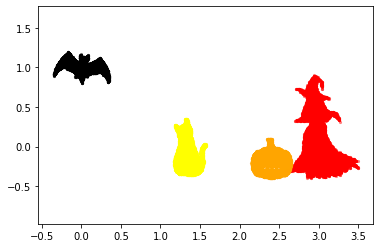

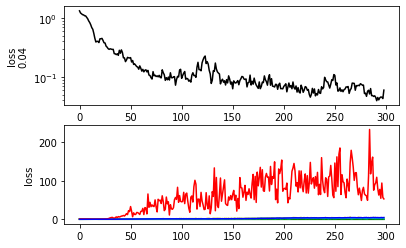

In [695]:
# # ## TRAIN halloween ish. base: noreg. sigma=7
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 7, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_noreg_sigma7/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:49,  1.77s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.7734 | Iter: 1.7721 | fit: 0.2492 | reg: 0.2027 | save: 0.0000) | autograd: 1.3160]


 17%|█▋        | 51/300 [01:47<18:22,  4.43s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.2024 | lr: 0.0001 | n_subsample: 378] 
[Total time : 107.7951 | Iter: 98.2338 | fit: 0.2914 | reg: 0.2299 | save: 7.7863) | autograd: 1.6922]


 34%|███▎      | 101/300 [03:49<15:58,  4.82s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.1199 | lr: 0.0001 | n_subsample: 476] 
[Total time : 229.3868 | Iter: 113.6670 | fit: 0.3078 | reg: 0.2639 | save: 7.9232) | autograd: 1.9764]


 50%|█████     | 151/300 [06:02<12:49,  5.16s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.1129 | lr: 0.0001 | n_subsample: 600] 
[Total time : 362.7209 | Iter: 124.8279 | fit: 0.3546 | reg: 0.3021 | save: 8.5042) | autograd: 2.0336]


 67%|██████▋   | 201/300 [08:31<08:43,  5.29s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0848 | lr: 0.0001 | n_subsample: 756] 
[Total time : 511.5620 | Iter: 141.0019 | fit: 0.4315 | reg: 0.2633 | save: 7.8366) | autograd: 2.1323]


 84%|████████▎ | 251/300 [11:12<04:34,  5.61s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0588 | lr: 5e-05 | n_subsample: 953] 
[Total time : 672.1854 | Iter: 152.2754 | fit: 0.3984 | reg: 0.3360 | save: 8.3465) | autograd: 2.4036]


100%|██████████| 300/300 [13:45<00:00,  2.75s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0676 | lr: 5e-05 | n_subsample: 953] 
[Total time : 825.5677 | Iter: 145.4070 | fit: 0.3848 | reg: 0.3274 | save: 7.9730) | autograd: 2.3895]


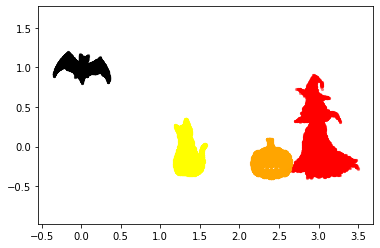

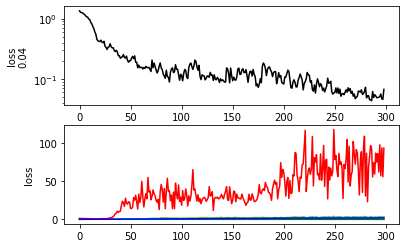

In [694]:
# # ## TRAIN halloween ish. base: noreg. sigma=5
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 5, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_noreg_sigma5/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:02<10:03,  2.02s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 2.0216 | Iter: 2.0204 | fit: 0.2680 | reg: 0.2150 | save: 0.0000) | autograd: 1.5320]


 17%|█▋        | 51/300 [01:47<18:15,  4.40s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0925 | lr: 0.0001 | n_subsample: 378] 
[Total time : 107.0731 | Iter: 96.9203 | fit: 0.2735 | reg: 0.2165 | save: 8.1293) | autograd: 1.4502]


 34%|███▎      | 101/300 [03:35<14:39,  4.42s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0678 | lr: 0.0001 | n_subsample: 476] 
[Total time : 215.4655 | Iter: 100.4384 | fit: 0.2944 | reg: 0.2118 | save: 7.9519) | autograd: 1.5343]


 50%|█████     | 151/300 [05:27<11:02,  4.44s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0728 | lr: 0.0001 | n_subsample: 600] 
[Total time : 327.6495 | Iter: 104.2438 | fit: 0.2959 | reg: 0.2294 | save: 7.9389) | autograd: 1.6023]


 67%|██████▋   | 201/300 [07:25<07:56,  4.81s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.1617 | lr: 5e-05 | n_subsample: 756] 
[Total time : 445.0762 | Iter: 108.8633 | fit: 0.3444 | reg: 0.2454 | save: 8.5619) | autograd: 1.5866]


 84%|████████▎ | 251/300 [09:23<03:40,  4.50s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0432 | lr: 5e-05 | n_subsample: 953] 
[Total time : 563.4756 | Iter: 110.4562 | fit: 0.3078 | reg: 0.2360 | save: 7.9426) | autograd: 1.5805]


100%|██████████| 300/300 [11:18<00:00,  2.26s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0352 | lr: 5e-05 | n_subsample: 953] 
[Total time : 678.8929 | Iter: 107.5246 | fit: 0.3160 | reg: 0.2443 | save: 7.8909) | autograd: 1.7048]


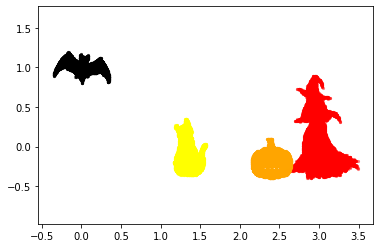

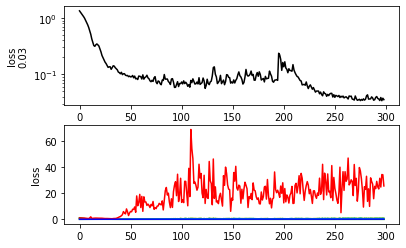

In [688]:
# # ## TRAIN halloween ish. base: jerk=.01. div 1
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_div1/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:39,  1.74s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.7384 | Iter: 1.7374 | fit: 0.2519 | reg: 0.2058 | save: 0.0000) | autograd: 1.2776]


 17%|█▋        | 51/300 [01:42<17:35,  4.24s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.3461 | lr: 0.0001 | n_subsample: 378] 
[Total time : 102.4661 | Iter: 92.8630 | fit: 0.2560 | reg: 0.2094 | save: 7.8632) | autograd: 1.3394]


 34%|███▎      | 101/300 [03:26<13:51,  4.18s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.3140 | lr: 0.0001 | n_subsample: 476] 
[Total time : 206.2434 | Iter: 96.4394 | fit: 0.2700 | reg: 0.2072 | save: 7.3358) | autograd: 1.5825]


 50%|█████     | 151/300 [05:14<10:40,  4.30s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.3209 | lr: 0.0001 | n_subsample: 600] 
[Total time : 314.9736 | Iter: 101.2186 | fit: 0.3137 | reg: 0.2085 | save: 7.5095) | autograd: 1.4878]


 67%|██████▋   | 201/300 [07:05<07:04,  4.28s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.3008 | lr: 5e-05 | n_subsample: 756] 
[Total time : 425.0030 | Iter: 102.4634 | fit: 0.2849 | reg: 0.2185 | save: 7.5629) | autograd: 1.4724]


 84%|████████▎ | 251/300 [09:01<03:52,  4.74s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.2479 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 541.8602 | Iter: 108.3880 | fit: 0.2872 | reg: 0.2481 | save: 8.4679) | autograd: 1.6588]


100%|██████████| 300/300 [10:56<00:00,  2.19s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.1889 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 656.2926 | Iter: 106.2977 | fit: 0.2870 | reg: 0.1966 | save: 8.1328) | autograd: 1.5284]


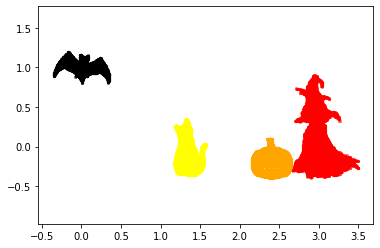

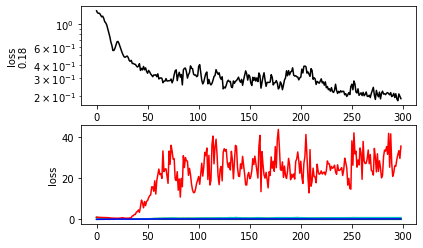

In [686]:
# # ## TRAIN halloween ish. base: jerk=.01. rigid 2
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_rigid/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

  0%|          | 1/300 [00:01<08:57,  1.80s/it]

Allocated: 0.11 GB  Reserved: 15.63 GB
[Loss: 2.3986 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.7991 | Iter: 1.7980 | fit: 0.2441 | reg: 0.1936 | save: 0.0000) | autograd: 1.3582]


 17%|█▋        | 51/300 [01:44<17:50,  4.30s/it]

Allocated: 0.11 GB  Reserved: 15.63 GB
[Loss: 0.4837 | lr: 0.0001 | n_subsample: 378] 
[Total time : 104.7681 | Iter: 95.4096 | fit: 0.2972 | reg: 0.2161 | save: 7.5579) | autograd: 1.3412]


 34%|███▎      | 101/300 [03:48<15:41,  4.73s/it]

Allocated: 0.11 GB  Reserved: 15.63 GB
[Loss: 0.1610 | lr: 0.0001 | n_subsample: 476] 
[Total time : 228.6747 | Iter: 116.1877 | fit: 0.4215 | reg: 0.2591 | save: 7.7167) | autograd: 1.5725]


 50%|█████     | 151/300 [06:08<12:20,  4.97s/it]

Allocated: 0.11 GB  Reserved: 15.63 GB
[Loss: 0.2399 | lr: 5e-05 | n_subsample: 600] 
[Total time : 368.8103 | Iter: 132.3587 | fit: 0.4486 | reg: 0.3092 | save: 7.7746) | autograd: 1.8925]


 67%|██████▋   | 201/300 [08:32<08:31,  5.17s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.2314 | lr: 2.5e-05 | n_subsample: 756] 
[Total time : 512.2681 | Iter: 135.4727 | fit: 0.4209 | reg: 0.3278 | save: 7.9837) | autograd: 2.0605]


 84%|████████▎ | 251/300 [10:56<03:57,  4.85s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.1116 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 656.5341 | Iter: 136.7501 | fit: 0.4212 | reg: 0.2585 | save: 7.5145) | autograd: 1.8553]


100%|██████████| 300/300 [13:19<00:00,  2.66s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0614 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 799.1177 | Iter: 134.8520 | fit: 0.4009 | reg: 0.3870 | save: 7.7297) | autograd: 2.1726]


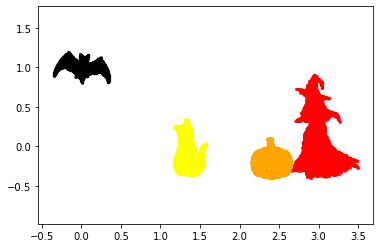

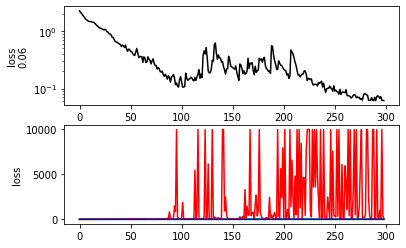

In [683]:
# # ## TRAIN halloween ish. base: jerk=.01. curl on trajectory .1
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_curlmean_p1/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:02<10:47,  2.17s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 2.1676 | Iter: 2.1657 | fit: 0.2866 | reg: 0.2382 | save: 0.0000) | autograd: 1.6386]


 17%|█▋        | 51/300 [01:46<18:14,  4.40s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0887 | lr: 0.0001 | n_subsample: 378] 
[Total time : 106.6454 | Iter: 96.4615 | fit: 0.2681 | reg: 0.2261 | save: 8.0145) | autograd: 1.5219]


 34%|███▎      | 101/300 [03:34<14:41,  4.43s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0717 | lr: 0.0001 | n_subsample: 476] 
[Total time : 214.1722 | Iter: 99.4958 | fit: 0.2988 | reg: 0.2039 | save: 8.0294) | autograd: 1.4960]


 50%|█████     | 151/300 [05:25<11:30,  4.63s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0952 | lr: 5e-05 | n_subsample: 600] 
[Total time : 325.2058 | Iter: 102.6573 | fit: 0.3050 | reg: 0.2244 | save: 8.3744) | autograd: 1.6551]


 67%|██████▋   | 201/300 [07:18<07:26,  4.51s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0940 | lr: 2.5e-05 | n_subsample: 756] 
[Total time : 438.0210 | Iter: 104.7067 | fit: 0.3008 | reg: 0.2305 | save: 8.1064) | autograd: 1.5269]


 84%|████████▎ | 251/300 [09:11<03:43,  4.56s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0748 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 551.3526 | Iter: 105.0068 | fit: 0.3070 | reg: 0.2212 | save: 8.3223) | autograd: 1.3897]


100%|██████████| 300/300 [11:02<00:00,  2.21s/it]

Allocated: 0.03 GB  Reserved: 15.63 GB
[Loss: 0.0714 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 662.5613 | Iter: 103.5278 | fit: 0.2754 | reg: 0.2131 | save: 7.6795) | autograd: 1.6145]


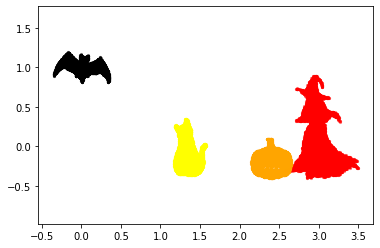

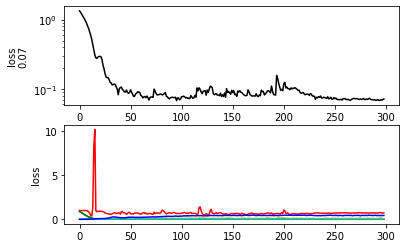

In [690]:
# # ## TRAIN halloween ish. base: jerk=.01. accel = 1
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_accel_1/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

  0%|          | 1/300 [00:01<09:12,  1.85s/it]

Allocated: 0.23 GB  Reserved: 15.63 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.8495 | Iter: 1.8481 | fit: 0.2570 | reg: 0.2087 | save: 0.0000) | autograd: 1.3804]


 17%|█▋        | 51/300 [01:48<18:50,  4.54s/it]

Allocated: 0.23 GB  Reserved: 15.63 GB
[Loss: 0.1468 | lr: 0.0001 | n_subsample: 378] 
[Total time : 108.1365 | Iter: 98.0145 | fit: 0.3062 | reg: 0.2324 | save: 8.2714) | autograd: 1.5594]


 34%|███▎      | 101/300 [03:37<14:57,  4.51s/it]

Allocated: 0.23 GB  Reserved: 15.63 GB
[Loss: 0.1279 | lr: 0.0001 | n_subsample: 476] 
[Total time : 217.4158 | Iter: 100.8884 | fit: 0.3112 | reg: 0.2229 | save: 8.3895) | autograd: 1.4175]


 50%|█████     | 151/300 [05:30<11:15,  4.53s/it]

Allocated: 0.23 GB  Reserved: 15.63 GB
[Loss: 0.1359 | lr: 5e-05 | n_subsample: 600] 
[Total time : 330.0366 | Iter: 104.5063 | fit: 0.2907 | reg: 0.2372 | save: 8.1123) | autograd: 1.4437]


 67%|██████▋   | 201/300 [07:22<07:21,  4.46s/it]

Allocated: 0.23 GB  Reserved: 15.63 GB
[Loss: 0.1471 | lr: 2.5e-05 | n_subsample: 756] 
[Total time : 442.7400 | Iter: 104.8476 | fit: 0.2910 | reg: 0.2250 | save: 7.8529) | autograd: 1.5633]


 84%|████████▎ | 251/300 [09:19<03:41,  4.53s/it]

Allocated: 0.23 GB  Reserved: 15.63 GB
[Loss: 0.1054 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 559.6568 | Iter: 108.8849 | fit: 0.3016 | reg: 0.2101 | save: 8.0295) | autograd: 1.5797]


100%|██████████| 300/300 [11:13<00:00,  2.24s/it]

Allocated: 0.23 GB  Reserved: 15.63 GB
[Loss: 0.0998 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 673.4199 | Iter: 105.6528 | fit: 0.3111 | reg: 0.2771 | save: 8.1094) | autograd: 1.6493]


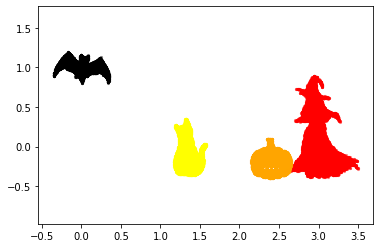

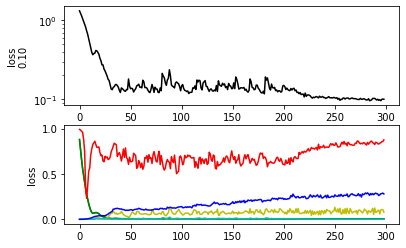

In [711]:
# # ## TRAIN halloween ish. base: jerk=.01. accel = 5
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_accel_5/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [621]:

# # # ## TRAIN carcination. jerk=.01. seems to look fine. not really going for a point here. but it looks cool enough i guess.
# # f1 = ImageDataset('frames/lobster.jpg',noise_std=0,thresh=.50,binary=False); 
# # f2 = ImageDataset('frames/crab.jpg',noise_std=0); 

# # n_inner = 10000;
# # n_sil = 10000 - n_inner;
# # dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1.7, -1], center = [0,0], rotate = 0),0); 
# # dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1], center = [.9,0], rotate = -np.pi/2),0); 

# # ezshow(dat1, col='red')
# # ezshow(dat2, col='blue')
# # plt.axis('equal')

# # keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
# # model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# # outfolder = "results/experiment_carcinization_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')
# # xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
# #                        nsteps=40, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=10, cycle=False, lw=0, contrast=2, Nrbf = 100000, keyframes=False, tightBB=True)
# # st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
# #                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

0.002426508309240849
1.427077660352828
-0.00021900775189986899
1.0636208112539218


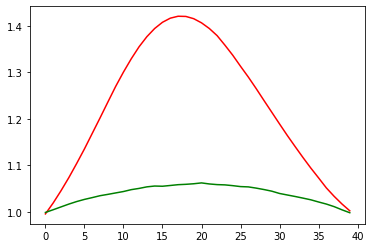

In [575]:
# # after running rect_base and rect_slight_div, run this to get areas.
# points = xt_trajs_1[0];
# areas = np.zeros(points.shape[2])
# for i in range(points.shape[2]):
#     chull = scipy.spatial.ConvexHull(points[:,:,i])
#     areas[i] = chull.volume
# areas1=areas

# points = xt_trajs_2[0];
# areas = np.zeros(points.shape[2])
# for i in range(points.shape[2]):
#     chull = scipy.spatial.ConvexHull(points[:,:,i])
#     areas[i] = chull.volume
# areas2=areas

# print(areas1[-1]-areas1[0]) 
# print(areas1.max()/areas1[0]) 

# print(areas2[-1]-areas2[0]) 
# print(areas2.max()/areas2[0]) 

# plt.plot(areas1/areas3[0],'r')
# plt.plot(areas2/areas3[0],'g')

# np.savetxt('results/outcache/areas1.txt', areas1)
# np.savetxt('results/outcache/areas2.txt', areas2)

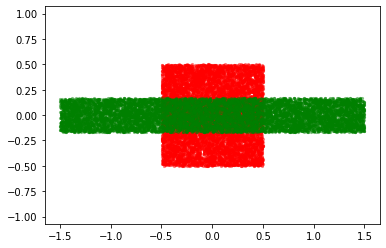

In [573]:
# # # # ## TRAIN rectangles. KE=.1, div=1
# n_inner = 10000;
# dat1 = torch.rand(n_inner,2)-.5
# dat2 = torch.rand(n_inner,2)-.5
# dat2[:,0]*=3;dat2[:,1]/=3;

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_rects_slight_div/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=40, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)
# xt_trajs_2 = xt_trajs

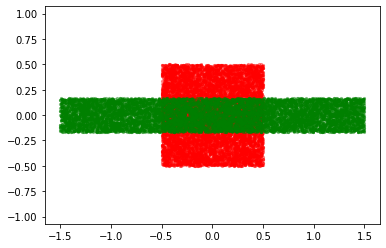

In [574]:
# # # ## TRAIN rectangles. KE=.1, div=0
# # optimal transport from (1,1) square to (.33,3) rectangle should result in an area increase of 33.3% at the middle of the trajectory.
# n_inner = 10000;
# dat1 = torch.rand(n_inner,2)-.5
# dat2 = torch.rand(n_inner,2)-.5
# dat2[:,0]*=3;dat2[:,1]/=3;

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_rects_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=40, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)
# xt_trajs_1 = xt_trajs

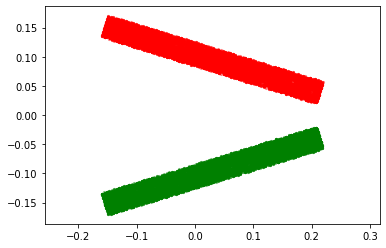

In [478]:
# # # ## TRAIN bars. KE=.01, rigid=10
# f1 = ImageDataset('frames/square.png',noise_std=0); 
# rotate = torch.tensor(.3)
# s, c = (torch.sin(rotate), torch.cos(rotate))
# rot = torch.stack([torch.stack([c, -s]), torch.stack([s, c])])

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, .1]),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, -.1]),0); 
# dat1 = dat1 @ rot
# dat2 = dat2 @ rot.t()

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_bars_more_rigid/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# # st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
# #                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [477]:
# # ## TRAIN bars. KE=.01, rigid=1
# f1 = ImageDataset('frames/square.png',noise_std=0); 
# rotate = torch.tensor(.3)
# s, c = (torch.sin(rotate), torch.cos(rotate))
# rot = torch.stack([torch.stack([c, -s]), torch.stack([s, c])])

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, .1]),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, -.1]),0); 
# dat1 = dat1 @ rot
# dat2 = dat2 @ rot.t()

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_bars_rigid/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

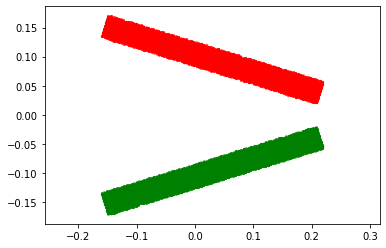

In [479]:
# # ## TRAIN bars. KE=.01
# f1 = ImageDataset('frames/square.png',noise_std=0); 
# rotate = torch.tensor(.3)
# s, c = (torch.sin(rotate), torch.cos(rotate))
# rot = torch.stack([torch.stack([c, -s]), torch.stack([s, c])])

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, .1]),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, -.1]),0); 
# dat1 = dat1 @ rot
# dat2 = dat2 @ rot.t()

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_bars_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# # st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
# #                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000,keyframes=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [177]:
# # horse down to horse up - jerk = .01
# im1 = ImageDataset('frames/horse1.jpg'); 
# im2 = ImageDataset('frames/horse2.jpg'); 
# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d1 = im1.sample(n_inner, n_sil, center = [1, .5]); 
# d2 = im2.sample(n_inner, n_sil, center = [1, .5], scale=[-1, -1]); 
# dat1 = torch.cat(d1,0)
# dat2 = torch.cat(d2,0)
# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_horseup_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder+'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# xt_trajs_OT = st.get_OT_trajectory(keyframes, nsteps=20, n=2000, ot_type=2)

# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=2, keyframes=False, Nrbf = 100000)

# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=2, keyframes=False, Nrbf = 100000, Nqvr=1, showVelocity=False)


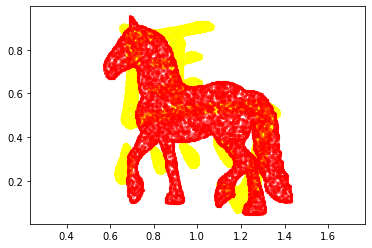

In [178]:
# # # horse character to horse - jerk = .01
# im1 = ImageDataset('frames/horse_charac.jpg'); 
# im2 = ImageDataset('frames/horse.jpg'); 

# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d1 = im1.sample(n_inner, n_sil, center = [1, .5]); 
# d2 = im2.sample(n_inner, n_sil, center = [1, .5], scale=[-1, -1]); 

# dat1 = torch.cat(d1,0)
# dat2 = torch.cat(d2,0)

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_horse_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder+'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=3, keyframes=False, Nrbf = 100000)

# xt_trajs_OT = st.get_OT_trajectory(keyframes, nsteps=20, n=2000, ot_type=2)
# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=3, keyframes=False, Nrbf = 100000, Nqvr=1, showVelocity=False)


/mnt/pzpzpzp1/anaconda3/envs/wassflow/lib/python3.8/site-packages/ot/lp/__init__.py:329: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


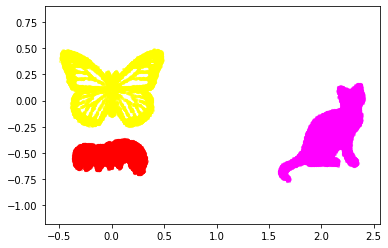

In [411]:
# # BUTTERFLY->CAT->CATERPILLAR - KE = .01, radialke = .1
# im1 = ImageDataset('frames/butterfly.jpg'); 
# im1b = ImageDataset('frames/butterflyfilled.jpg'); 
# im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
# im6 = ImageDataset('frames/cat1.png'); 

# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
# d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
# d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
# d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

# dat1 = torch.cat((d1a[0], d1b[1]),0)
# dat2 = torch.cat(d2,0)
# dat6 = torch.cat(d6,0)

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat6, col='magenta')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_BCC_radial/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder+'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=4000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=1, contrast=3, Nrbf = 100000)

In [448]:
# # BUTTERFLY->CAT->CATERPILLAR - base. KE = .01
# im1 = ImageDataset('frames/butterfly.jpg'); 
# im1b = ImageDataset('frames/butterflyfilled.jpg'); 
# im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
# im6 = ImageDataset('frames/cat1.png'); 

# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
# d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
# d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
# d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

# dat1 = torch.cat((d1a[0], d1b[1]),0)
# dat2 = torch.cat(d2,0)
# dat6 = torch.cat(d6,0)

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat6, col='magenta')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_BCC_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder+'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=4000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=1, contrast=3, Nrbf = 100000)

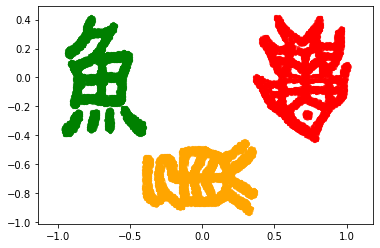

In [188]:
# ## TRAIN FISH234 cycle. Jerk=.01. signedcurl=.1 curl everywhere
# f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
# f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
# f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

# ezshow(dat2, col='red')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat2, dat3, dat4)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_fish234_signedcurl_even/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=30, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, Nrbf = 100000)

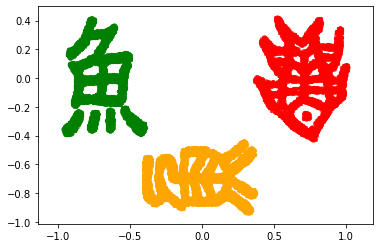

In [189]:
# ## TRAIN FISH234 cycle. Jerk=.01. signedcurl=.1 average curl
# f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
# f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
# f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

# ezshow(dat2, col='red')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat2, dat3, dat4)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_fish234_signedcurl/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, Nrbf = 100000)

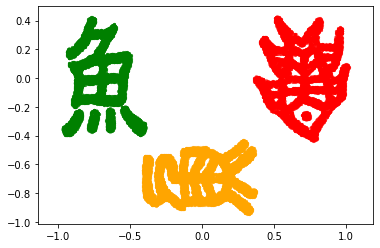

In [191]:
# ## TRAIN FISH234 cycle. Jerk=.01.
# f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
# f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
# f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

# ezshow(dat2, col='red')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat2, dat3, dat4)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_fish234/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, Nrbf = 100000)

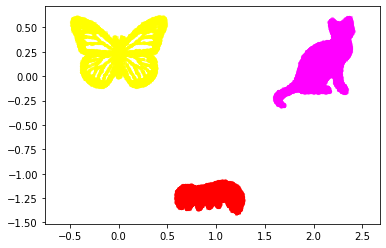

In [346]:
# ## GENERATE CYCLIC BUTTERFLY->CAT->CATERPILLAR. enforce completely cyclic.
# im1 = ImageDataset('frames/butterfly.jpg'); 
# im1b = ImageDataset('frames/butterflyfilled.jpg'); 
# im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
# im6 = ImageDataset('frames/cat1.png'); 

# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [1, -1.2]); 
# d1a = im1.sample(n_inner, n_sil, center = [0, .13]); 
# d1b = im1b.sample(n_inner, n_sil, center = [0, .13]); 
# d6 = im6.sample(n_inner, n_sil, center = [2, .15]); 

# dat1 = torch.cat((d1a[0], d1b[1]),0)
# dat2 = torch.cat(d2,0)
# dat6 = torch.cat(d6,0)

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat6, col='magenta')

# ## TRAIN CYCLIC BUTTERFLY->CAT->CATERPILLAR. .1 radial, .01 jerk
# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2, dat1)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 4, in_features=3, out_features=2, incrementalMask = True,  Tperiod = len(keyframes)-1).to(device)
# outfolder = "results/experiment_BCC_cyclic/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=True, lw=.5, contrast=3, Nrbf = 100000)

In [433]:
## TRAIN umbrella. Jerk=.01. poor temporal consistency because of discretized ot registration.
# f1 = ImageDataset('frames/birdflock_start.jpg',noise_std=0,thresh=.9,binary=False); 
# f2 = ImageDataset('frames/umbrella.jpg',noise_std=0,thresh=.9); 
# f3 = ImageDataset('frames/birdflock_end.jpg',noise_std=.1,thresh=1,binary=False); 

# # dat1 = torch.cat(f1.sample(1000, 0, scale = [1.5, -1.2], center = [-1.5, .125], rotate = 0),0); 
# # dat1 = torch.randn(1000,2); dat1[:,0]*=.5; dat1[:,1]*=.2; dat1[:,0]-=.6
# dat2 = torch.randn(1000,2); dat2[:,0]*=.2; dat2[:,1]*=.1; dat2[:,0]-=.2; dat2[:,1]+=.1
# dat1 = dat2.clone(); dat1[:,0]-=.5
# dat3 = torch.cat(f2.sample(900, 100, scale = [1, -1.1], center = [.13, -.05], rotate = 0),0); 
# dat4 = torch.cat(f3.sample(1000, 0, scale = [2, -2], center = [.2, .2], rotate = 0),0); 
# dat5 = torch.randn(1000,2); dat5[:,0]*=.8; dat5[:,1]*=.8; dat5[:,1]+=.5

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='orange')
# ezshow(dat3, col='red')
# ezshow(dat4, col='blue')
# # ezshow(dat5, col='green')

# # keyframes = torch.stack((dat1, dat2, dat3, dat4, dat5)).to(device);
# keyframes = torch.stack((dat1, dat2, dat3, dat4)).to(device);

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_umbrella_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = True, lr = 1e-4, scaling = .4, normalize=False)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=100)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_points',
#                        dpiv=600, sigma=.01, knn=1, cycle=False, lw=.01, contrast=1, Nrbf = 0, keyframes=False, showVelocity=False, plotKeypoints=True)

  0%|          | 1/300 [00:01<06:17,  1.26s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 1.4283 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.2656 | Iter: 1.2646 | fit: 0.1615 | reg: 0.1441 | save: 0.0000) | autograd: 0.9565]


 17%|█▋        | 51/300 [01:06<11:51,  2.86s/it]

Allocated: 1.57 GB  Reserved: 15.63 GB
[Loss: 0.3371 | lr: 0.0001 | n_subsample: 378] 
[Total time : 66.6161 | Iter: 59.8440 | fit: 0.1636 | reg: 0.1170 | save: 5.5043) | autograd: 0.8742]


 34%|███▎      | 101/300 [02:12<09:20,  2.82s/it]

Allocated: 1.57 GB  Reserved: 15.63 GB
[Loss: 0.3396 | lr: 5e-05 | n_subsample: 476] 
[Total time : 132.4476 | Iter: 60.5799 | fit: 0.1658 | reg: 0.1524 | save: 5.2498) | autograd: 0.9734]


 50%|█████     | 151/300 [03:21<07:07,  2.87s/it]

Allocated: 1.57 GB  Reserved: 15.63 GB
[Loss: 0.3378 | lr: 5e-05 | n_subsample: 600] 
[Total time : 201.4681 | Iter: 63.7727 | fit: 0.1676 | reg: 0.1376 | save: 5.2468) | autograd: 0.9934]


 67%|██████▋   | 201/300 [04:33<04:56,  2.99s/it]

Allocated: 1.57 GB  Reserved: 15.63 GB
[Loss: 0.4077 | lr: 2.5e-05 | n_subsample: 756] 
[Total time : 273.1370 | Iter: 66.1828 | fit: 0.1910 | reg: 0.1483 | save: 5.4846) | autograd: 1.0452]


 84%|████████▎ | 251/300 [05:44<02:21,  2.89s/it]

Allocated: 1.57 GB  Reserved: 15.63 GB
[Loss: 0.3418 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 344.4157 | Iter: 66.0161 | fit: 0.1831 | reg: 0.1476 | save: 5.2610) | autograd: 0.9882]


 99%|█████████▉| 298/300 [06:47<00:02,  1.37s/it]


KeyboardInterrupt: 

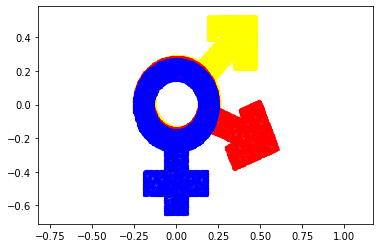

In [254]:
## TRAIN MF. Jerk=.01, div=1, rig.1
f1 = ImageDataset('frames/male.jpg',noise_std=0); 
f2 = ImageDataset('frames/female.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.11, .125], rotate = 0),0); 
dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.13, -.05], rotate = -np.pi*.375),0); 
dat3 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, -.2], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='blue')

keyframes = torch.stack((dat1, dat2, dat3)).to(device);

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MMF_rigdiv/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=False)
# model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=10, cycle=True, lw=0, contrast=3, Nrbf = 100000,keyframes=False)

In [211]:
## TRAIN MF. Jerk=.01, 
# f1 = ImageDataset('frames/male.jpg',noise_std=0); 
# f2 = ImageDataset('frames/female.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.2, .5], rotate = -np.pi/7),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 4, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_MF2_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=10, cycle=True, lw=0, contrast=3, Nrbf = 100000,keyframes=False)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<05:04,  1.02s/it]

Allocated: 1.59 GB  Reserved: 15.63 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.0199 | Iter: 1.0185 | fit: 0.1609 | reg: 0.1128 | save: 0.0000) | autograd: 0.7416]


 17%|█▋        | 51/300 [01:09<12:36,  3.04s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.3441 | lr: 0.0001 | n_subsample: 378] 
[Total time : 69.6420 | Iter: 62.9471 | fit: 0.1868 | reg: 0.1372 | save: 5.6740) | autograd: 0.8993]


 34%|███▎      | 101/300 [02:25<10:08,  3.06s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.3578 | lr: 0.0001 | n_subsample: 476] 
[Total time : 145.1821 | Iter: 70.2046 | fit: 0.1969 | reg: 0.1716 | save: 5.3335) | autograd: 1.0983]


 50%|█████     | 151/300 [03:44<08:02,  3.24s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.4450 | lr: 5e-05 | n_subsample: 600] 
[Total time : 224.9955 | Iter: 74.2470 | fit: 0.2310 | reg: 0.1714 | save: 5.5647) | autograd: 1.1294]


 67%|██████▋   | 201/300 [05:10<05:29,  3.33s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.7271 | lr: 2.5e-05 | n_subsample: 756] 
[Total time : 310.1174 | Iter: 79.7126 | fit: 0.2286 | reg: 0.1603 | save: 5.4075) | autograd: 1.2425]


 84%|████████▎ | 251/300 [06:44<02:42,  3.32s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.4111 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 404.3090 | Iter: 88.8316 | fit: 0.2097 | reg: 0.1827 | save: 5.3577) | autograd: 1.3951]


100%|██████████| 300/300 [08:14<00:00,  1.65s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.3737 | lr: 6.25e-06 | n_subsample: 953] 
[Total time : 494.1192 | Iter: 84.2216 | fit: 0.2187 | reg: 0.1752 | save: 5.5872) | autograd: 1.2826]


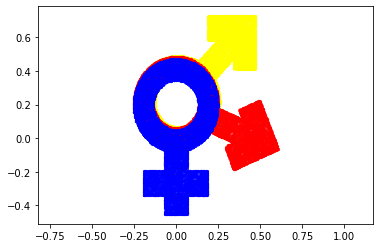

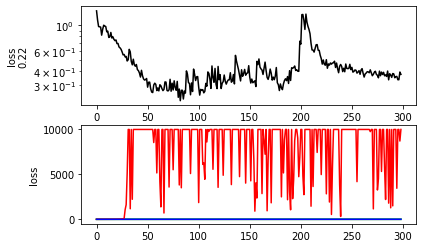

In [244]:
# ## TRAIN MF. Jerk=.01
# f1 = ImageDataset('frames/male.jpg',noise_std=0); 
# f2 = ImageDataset('frames/female.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.11, .325], rotate = 0),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.13, .15], rotate = -np.pi*.375),0); 
# dat3 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat3, col='blue')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_MMF_base/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=10, cycle=True, lw=0, contrast=3, Nrbf = 100000,keyframes=False)

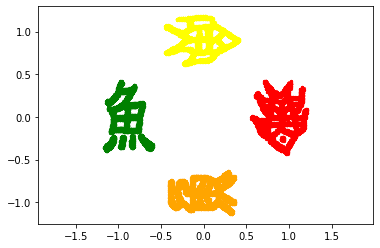

In [3]:
## GENERATE FISH IMAGES
f1 = ImageDataset('frames/fish1.jpg',noise_std=0); 
f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1.2, -1], center = [-.07, .9], rotate = -np.pi/2),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.9, 0], rotate = -np.pi),0); 
dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.9], rotate = np.pi/2),0); 
dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.9, 0], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:18,  1.67s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.6699 | Iter: 1.6686 | fit: 0.2464 | reg: 0.1671 | save: 0.0000) | autograd: 1.2527]


 17%|█▋        | 51/300 [01:43<19:00,  4.58s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1920 | lr: 0.0001 | n_subsample: 378] 
[Total time : 103.9631 | Iter: 93.7369 | fit: 0.3000 | reg: 0.2471 | save: 8.5544) | autograd: 1.4761]


 34%|███▎      | 101/300 [03:34<15:39,  4.72s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1101 | lr: 0.0001 | n_subsample: 476] 
[Total time : 214.0755 | Iter: 101.5491 | fit: 0.2889 | reg: 0.3074 | save: 8.5499) | autograd: 1.6385]


 50%|█████     | 151/300 [05:26<11:23,  4.59s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1075 | lr: 0.0001 | n_subsample: 600] 
[Total time : 326.8526 | Iter: 104.3059 | fit: 0.3084 | reg: 0.2223 | save: 8.4693) | autograd: 1.3802]


 67%|██████▋   | 201/300 [07:19<07:31,  4.56s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1214 | lr: 5e-05 | n_subsample: 756] 
[Total time : 439.0355 | Iter: 103.9125 | fit: 0.3310 | reg: 0.2352 | save: 8.2688) | autograd: 1.4705]


 84%|████████▎ | 251/300 [09:13<03:42,  4.54s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.0705 | lr: 5e-05 | n_subsample: 953] 
[Total time : 553.5966 | Iter: 106.6982 | fit: 0.3403 | reg: 0.2791 | save: 7.8617) | autograd: 1.6063]


100%|██████████| 300/300 [11:08<00:00,  2.23s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.0553 | lr: 5e-05 | n_subsample: 953] 
[Total time : 668.6479 | Iter: 107.2663 | fit: 0.3158 | reg: 0.2857 | save: 7.7836) | autograd: 1.6296]


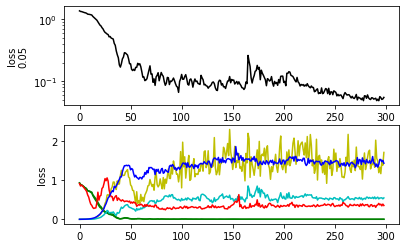

In [136]:
## TRAIN FISH1234 circle. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_circle/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [137]:
# RENDER ABOVE
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_circle/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

In [147]:
## TRAIN FISH1234 circle. Jerk=.01. rigid=.1, curl-pi=.1
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_circle_morecurl_andrigid/"
model.load_state(outfolder + 'models/state_0050.tar')
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=953, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 5e-5, scaling = .4)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:03<15:33,  3.12s/it]

Allocated: 0.29 GB  Reserved: 1.42 GB
[Loss: 1.4531 | lr: 5e-05 | n_subsample: 953] 
[Total time : 3.1238 | Iter: 3.1217 | fit: 0.5234 | reg: 0.2963 | save: 0.0000) | autograd: 2.2986]


 17%|█▋        | 51/300 [02:31<20:38,  4.97s/it]

Allocated: 0.29 GB  Reserved: 1.42 GB
[Loss: 1.4929 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 151.2456 | Iter: 140.8943 | fit: 0.3583 | reg: 0.3238 | save: 7.2266) | autograd: 2.1432]


 27%|██▋       | 82/300 [04:05<10:51,  2.99s/it]


KeyboardInterrupt: 

In [148]:
# RENDER ABOVE
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_circle_morecurl_andrigid/"
# model.load_state(outfolder + 'models/state_final.tar')
model.load_state(outfolder + 'models/state_0050.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True, lw=2)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:00<03:09,  1.58it/s]

Allocated: 0.04 GB  Reserved: 1.03 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6351 | Iter: 0.6342 | fit: 0.1119 | reg: 0.0890 | save: 0.0000) | autograd: 0.4308]


 17%|█▋        | 51/300 [00:37<07:26,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1390 | lr: 0.0001 | n_subsample: 378] 
[Total time : 37.4436 | Iter: 33.1441 | fit: 0.0998 | reg: 0.0897 | save: 3.6630) | autograd: 0.5577]


 34%|███▎      | 101/300 [01:15<06:03,  1.83s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1245 | lr: 0.0001 | n_subsample: 476] 
[Total time : 75.2739 | Iter: 34.0856 | fit: 0.1107 | reg: 0.0971 | save: 3.7426) | autograd: 0.5434]


 50%|█████     | 151/300 [01:52<04:31,  1.82s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1156 | lr: 0.0001 | n_subsample: 600] 
[Total time : 112.8752 | Iter: 33.7381 | fit: 0.0944 | reg: 0.0814 | save: 3.8616) | autograd: 0.5019]


 67%|██████▋   | 201/300 [02:30<03:07,  1.89s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1259 | lr: 0.0001 | n_subsample: 756] 
[Total time : 150.5676 | Iter: 33.7116 | fit: 0.0999 | reg: 0.0975 | save: 3.9791) | autograd: 0.5305]


 84%|████████▎ | 251/300 [03:08<01:30,  1.86s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1135 | lr: 5e-05 | n_subsample: 953] 
[Total time : 188.3963 | Iter: 33.8876 | fit: 0.0847 | reg: 0.0793 | save: 3.9390) | autograd: 0.4525]


 89%|████████▊ | 266/300 [03:18<00:25,  1.34it/s]


KeyboardInterrupt: 

In [74]:
## TRAIN MF. Jerk=.01, rigid=2
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF2_rigid/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

  0%|          | 1/300 [00:00<03:04,  1.62it/s]

Allocated: 0.04 GB  Reserved: 1.03 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6200 | Iter: 0.6191 | fit: 0.0922 | reg: 0.0759 | save: 0.0000) | autograd: 0.4474]


 17%|█▋        | 51/300 [00:37<07:46,  1.87s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1831 | lr: 0.0001 | n_subsample: 378] 
[Total time : 37.4737 | Iter: 32.8240 | fit: 0.0935 | reg: 0.0831 | save: 4.0279) | autograd: 0.4340]


 34%|███▎      | 101/300 [01:15<06:07,  1.85s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1172 | lr: 0.0001 | n_subsample: 476] 
[Total time : 75.4136 | Iter: 34.0470 | fit: 0.0942 | reg: 0.0915 | save: 3.8900) | autograd: 0.4968]


 50%|█████     | 151/300 [01:53<04:26,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1040 | lr: 0.0001 | n_subsample: 600] 
[Total time : 113.0945 | Iter: 33.9536 | fit: 0.0892 | reg: 0.0810 | save: 3.7249) | autograd: 0.4552]


 67%|██████▋   | 201/300 [02:30<03:06,  1.88s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1136 | lr: 5e-05 | n_subsample: 756] 
[Total time : 150.9560 | Iter: 33.8102 | fit: 0.1070 | reg: 0.0902 | save: 4.0488) | autograd: 0.4604]


 79%|███████▉  | 238/300 [02:57<00:46,  1.34it/s]


KeyboardInterrupt: 

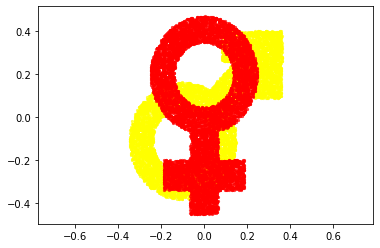

In [60]:
## GENERATE MF IMAGES
f1 = ImageDataset('frames/male.jpg',noise_std=0); 
f2 = ImageDataset('frames/female.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:00<03:27,  1.44it/s]

Allocated: 0.04 GB  Reserved: 1.02 GB
[Loss: 1.4143 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6952 | Iter: 0.6937 | fit: 0.0843 | reg: 0.0767 | save: 0.0000) | autograd: 0.5310]


 17%|█▋        | 51/300 [00:35<07:26,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.4322 | lr: 0.0001 | n_subsample: 378] 
[Total time : 35.7798 | Iter: 31.1586 | fit: 0.0882 | reg: 0.0673 | save: 3.9235) | autograd: 0.4004]


 34%|███▎      | 101/300 [01:10<05:36,  1.69s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.3080 | lr: 0.0001 | n_subsample: 476] 
[Total time : 70.9569 | Iter: 31.7238 | fit: 0.0863 | reg: 0.0769 | save: 3.4512) | autograd: 0.5186]


 50%|█████     | 151/300 [01:46<04:25,  1.78s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.2970 | lr: 0.0001 | n_subsample: 600] 
[Total time : 106.5074 | Iter: 31.7220 | fit: 0.1080 | reg: 0.0936 | save: 3.8269) | autograd: 0.4359]


 67%|██████▋   | 201/300 [02:22<02:54,  1.77s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.3618 | lr: 5e-05 | n_subsample: 756] 
[Total time : 142.7839 | Iter: 32.6935 | fit: 0.1028 | reg: 0.0994 | save: 3.5814) | autograd: 0.5227]


 84%|████████▎ | 251/300 [02:59<01:28,  1.80s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.3162 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 179.2403 | Iter: 32.6641 | fit: 0.0928 | reg: 0.0797 | save: 3.7908) | autograd: 0.5038]


100%|██████████| 300/300 [03:34<00:00,  1.40it/s]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.2707 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 214.8629 | Iter: 31.6494 | fit: 0.0932 | reg: 0.0837 | save: 3.9712) | autograd: 0.5222]


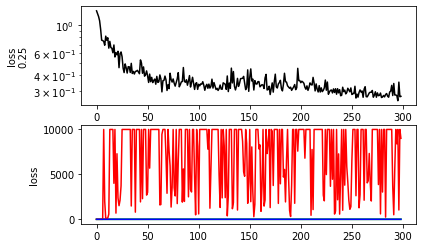

In [65]:
## TRAIN MF. Jerk=.01, rigid=2
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF_rigid/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:00<03:07,  1.60it/s]

Allocated: 0.03 GB  Reserved: 1.01 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6274 | Iter: 0.6263 | fit: 0.0832 | reg: 0.0823 | save: 0.0000) | autograd: 0.4586]


 17%|█▋        | 51/300 [00:35<07:25,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.5581 | lr: 0.0001 | n_subsample: 378] 
[Total time : 35.1488 | Iter: 30.6600 | fit: 0.0877 | reg: 0.0798 | save: 3.8600) | autograd: 0.4628]


 34%|███▎      | 101/300 [01:11<06:15,  1.89s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.4963 | lr: 0.0001 | n_subsample: 476] 
[Total time : 71.0976 | Iter: 31.8908 | fit: 0.0819 | reg: 0.0695 | save: 4.0568) | autograd: 0.4971]


 50%|█████     | 151/300 [01:49<04:39,  1.87s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.5125 | lr: 0.0001 | n_subsample: 600] 
[Total time : 109.5515 | Iter: 34.5990 | fit: 0.0873 | reg: 0.1097 | save: 3.8513) | autograd: 0.5431]


 67%|██████▋   | 201/300 [02:29<03:04,  1.86s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.3814 | lr: 0.0001 | n_subsample: 756] 
[Total time : 149.2541 | Iter: 35.9197 | fit: 0.1049 | reg: 0.0836 | save: 3.7813) | autograd: 0.5521]


 84%|████████▎ | 251/300 [03:09<01:32,  1.88s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.3118 | lr: 0.0001 | n_subsample: 953] 
[Total time : 189.5597 | Iter: 36.4566 | fit: 0.1177 | reg: 0.0937 | save: 3.8477) | autograd: 0.5663]


100%|██████████| 300/300 [03:49<00:00,  1.31it/s]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.3109 | lr: 0.0001 | n_subsample: 953] 
[Total time : 229.2548 | Iter: 36.0819 | fit: 0.1037 | reg: 0.0811 | save: 3.6115) | autograd: 0.5136]


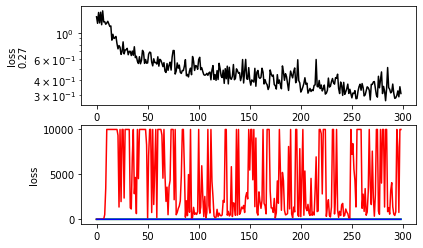

In [61]:
## TRAIN MF. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF_base/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

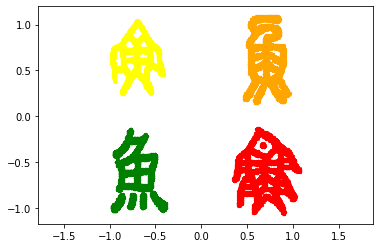

In [40]:
## GENERATE FISH IMAGES
f1 = ImageDataset('frames/fish1.jpg',noise_std=0); 
f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [-.7, .6], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [.7, -.6], rotate = 0),0); 
dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [1, -1.1], center = [.7, .6], rotate = 0),0); 
dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [1, -1.1], center = [-.7, -.6], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:46,  1.76s/it]

Allocated: 0.04 GB  Reserved: 0.99 GB
[Loss: 1.4143 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.7621 | Iter: 1.7605 | fit: 0.2533 | reg: 0.2061 | save: 0.0000) | autograd: 1.2984]


 17%|█▋        | 51/300 [01:44<18:24,  4.43s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.2327 | lr: 0.0001 | n_subsample: 378] 
[Total time : 104.6191 | Iter: 95.3438 | fit: 0.3409 | reg: 0.2402 | save: 7.5109) | autograd: 1.5946]


 34%|███▎      | 101/300 [03:47<14:42,  4.43s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.2681 | lr: 5e-05 | n_subsample: 476] 
[Total time : 227.1926 | Iter: 115.3376 | fit: 0.3866 | reg: 0.2328 | save: 7.2337) | autograd: 1.5654]


 50%|█████     | 151/300 [05:48<10:57,  4.41s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.4412 | lr: 2.5e-05 | n_subsample: 600] 
[Total time : 348.9586 | Iter: 114.5010 | fit: 0.3569 | reg: 0.2886 | save: 7.2634) | autograd: 1.6906]


 67%|██████▋   | 201/300 [07:51<07:33,  4.59s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.4429 | lr: 1.25e-05 | n_subsample: 756] 
[Total time : 471.0927 | Iter: 114.8102 | fit: 0.3559 | reg: 0.2746 | save: 7.3222) | autograd: 1.5808]


 84%|████████▎ | 251/300 [09:55<03:41,  4.51s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1771 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 595.1450 | Iter: 116.7083 | fit: 0.3815 | reg: 0.2988 | save: 7.3428) | autograd: 1.6202]


100%|██████████| 300/300 [11:56<00:00,  2.39s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1040 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 716.7629 | Iter: 114.2267 | fit: 0.3655 | reg: 0.3002 | save: 7.3898) | autograd: 1.7368]


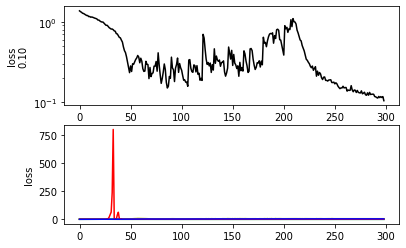

In [50]:
## TRAIN FISH1234. Jerk=.01, curl=3
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_min3curl/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [51]:
# RENDER FISH1234. Jerk=.01, curl=3
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_min3curl/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:16,  1.66s/it]

Allocated: 0.05 GB  Reserved: 0.99 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.6610 | Iter: 1.6594 | fit: 0.2434 | reg: 0.1921 | save: 0.0000) | autograd: 1.2209]


 17%|█▋        | 51/300 [01:45<17:52,  4.31s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.5209 | lr: 0.0001 | n_subsample: 378] 
[Total time : 105.2580 | Iter: 95.9364 | fit: 0.3437 | reg: 0.1897 | save: 7.6591) | autograd: 1.3182]


 34%|███▎      | 101/300 [03:49<15:07,  4.56s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1761 | lr: 0.0001 | n_subsample: 476] 
[Total time : 229.2284 | Iter: 116.5423 | fit: 0.3739 | reg: 0.2689 | save: 7.4254) | autograd: 1.7431]


 50%|█████     | 151/300 [05:55<11:28,  4.62s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1539 | lr: 0.0001 | n_subsample: 600] 
[Total time : 355.2608 | Iter: 118.4871 | fit: 0.3641 | reg: 0.2838 | save: 7.5440) | autograd: 1.6461]


 67%|██████▋   | 201/300 [08:04<07:44,  4.69s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.6395 | lr: 5e-05 | n_subsample: 756] 
[Total time : 484.4383 | Iter: 121.8992 | fit: 0.3713 | reg: 0.2942 | save: 7.2771) | autograd: 1.7430]


 84%|████████▎ | 251/300 [10:15<03:42,  4.54s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1229 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 615.0932 | Iter: 123.6742 | fit: 0.3708 | reg: 0.2979 | save: 6.9787) | autograd: 1.8265]


100%|██████████| 300/300 [12:23<00:00,  2.48s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.0903 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 743.0334 | Iter: 120.4441 | fit: 0.3626 | reg: 0.3111 | save: 7.4941) | autograd: 1.7717]


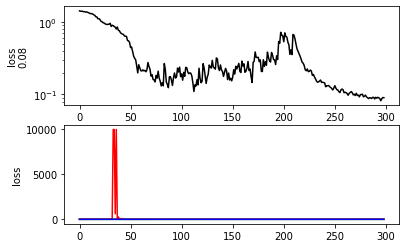

In [48]:
## TRAIN FISH1234. Jerk=.01, curl=1
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_mincurl/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<09:12,  1.85s/it]

Allocated: 0.05 GB  Reserved: 1.0 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.8488 | Iter: 1.8475 | fit: 0.2582 | reg: 0.2061 | save: 0.0000) | autograd: 1.3796]


 17%|█▋        | 51/300 [01:47<19:06,  4.60s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.2806 | lr: 0.0001 | n_subsample: 378] 
[Total time : 107.8846 | Iter: 98.4241 | fit: 0.3488 | reg: 0.2998 | save: 7.6107) | autograd: 1.6644]


 34%|███▎      | 101/300 [03:50<14:45,  4.45s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0799 | lr: 0.0001 | n_subsample: 476] 
[Total time : 230.3337 | Iter: 114.9874 | fit: 0.3471 | reg: 0.2256 | save: 7.4600) | autograd: 1.5489]


 50%|█████     | 151/300 [05:53<11:26,  4.61s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0714 | lr: 0.0001 | n_subsample: 600] 
[Total time : 353.3889 | Iter: 115.5960 | fit: 0.3541 | reg: 0.3052 | save: 7.4567) | autograd: 1.7868]


 67%|██████▋   | 201/300 [07:58<07:46,  4.72s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.1048 | lr: 5e-05 | n_subsample: 756] 
[Total time : 478.6190 | Iter: 117.4761 | fit: 0.3444 | reg: 0.2570 | save: 7.7523) | autograd: 1.6729]


 84%|████████▎ | 251/300 [10:05<03:47,  4.65s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0581 | lr: 5e-05 | n_subsample: 953] 
[Total time : 605.9871 | Iter: 119.4879 | fit: 0.3579 | reg: 0.2180 | save: 7.8780) | autograd: 1.5187]


100%|██████████| 300/300 [12:11<00:00,  2.44s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0424 | lr: 5e-05 | n_subsample: 953] 
[Total time : 731.2351 | Iter: 117.9243 | fit: 0.3798 | reg: 0.2288 | save: 7.3214) | autograd: 1.5924]


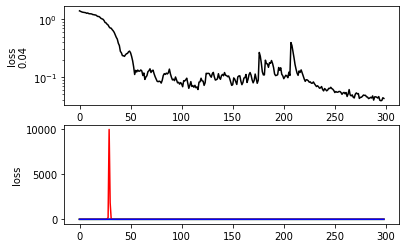

In [55]:
## TRAIN FISH1234. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [56]:
# RENDER FISH1234
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

In [ ]:
## GENERATE BUNCH OF IMAGES
im1 = ImageDataset('frames/butterfly.jpg'); 
im1b = ImageDataset('frames/butterflyfilled.jpg'); 
im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
im3 = ImageDataset('frames/circle.jpeg'); 
im4 = ImageDataset('frames/baldhead.jpeg'); 
im5 = ImageDataset('frames/square.png'); 
im6 = ImageDataset('frames/cat1.png'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
d3 = im3.sample(n_inner, n_sil, center = [1, .5]); 
d4 = im4.sample(n_inner, n_sil, center = [1, -.5]); 
d5 = im5.sample(n_inner, n_sil, center = [1.9, .3]); 
d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat3 = torch.cat(d3,0)
dat4 = torch.cat(d4,0)
dat5 = torch.cat(d5,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')
ezshow(dat5, col='blue')
ezshow(dat6, col='magenta')